In [ ]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2
from google.colab.patches import cv2_imshow

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python


## Загрузка изображения

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
urllib.request.urlretrieve(url, "image.jpg")


('image.jpg', <http.client.HTTPMessage at 0x7b838cd42e60>)

In [ ]:
img = np.array(Image.open("image.jpg"))


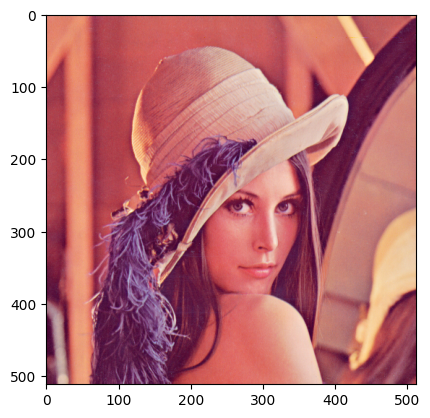

In [ ]:
plt.imshow(img)
plt.show()

# Задание 1 Изменение размера изображения

In [ ]:
size_factor = 10

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
res_img = np.array(img.resize((img.shape[0]// size_factor, img.shape[1]// size_factor)))

In [ ]:
def resize_nn(img, size_factor):
  new_height = int(img.shape[0] * size_factor)
  new_width = int(img.shape[1] * size_factor)
  new_img = np.zeros(shape=(new_height, new_width, img.shape[2]), dtype=img.dtype)

  for x in range(new_width):
    for y in range(new_height):
      orig_x = int(x / size_factor)
      orig_y = int(y / size_factor)
      new_img[x][y] = img[orig_x][orig_y]
  return new_img

import math
def resize_bilinear(img, size_factor):
  original_height, original_width = img.shape[:2]
  new_height = int(original_height * size_factor)
  new_width = int(original_width * size_factor)
  new_img = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)

  height_scale = (original_height-1) / (new_height-1)
  width_scale  = (original_width-1) / (new_width-1)

  for i in range(new_height):
    for j in range(new_width):

      x_l, y_l = math.floor(width_scale * j), math.floor(height_scale * i)
      x_h, y_h = math.ceil(width_scale * j), math.ceil(height_scale * i)

      x_weight = (width_scale * j) - x_l
      y_weight = (height_scale * i) - y_l

      a = img[y_l, x_l]
      b = img[y_l, x_h]
      c = img[y_h, x_l]
      d = img[y_h, x_h]

      pixel = a * (1 - x_weight) * (1 - y_weight) + b * x_weight * (1 - y_weight) + c * y_weight * (1 - x_weight) + d * x_weight * y_weight

      new_img[i][j] = pixel

  return new_img

In [ ]:
resized1 = resize_nn(res_img, size_factor)
resized2 = resize_bilinear(res_img, size_factor)


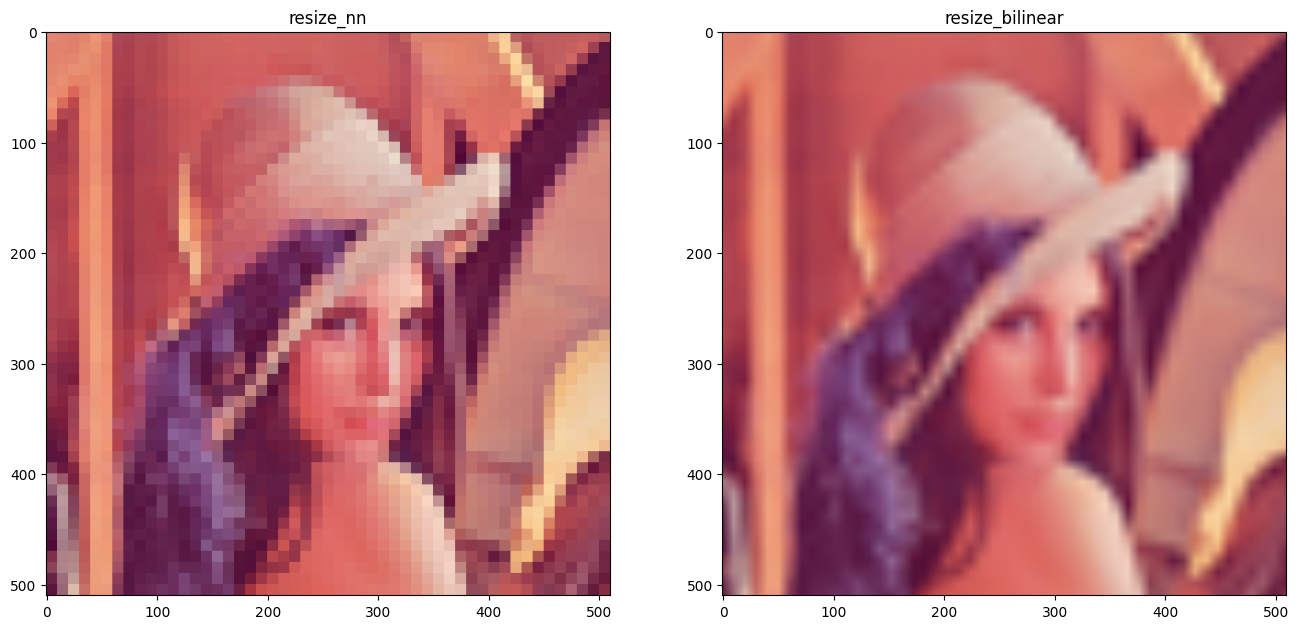

In [ ]:
figure, axes = plt.subplots(1, 2)
figure.set_figwidth(16)
figure.set_figheight(8)

axes[0].imshow(resized1)
axes[0].set_title("resize_nn")

axes[1].imshow(resized2)
axes[1].set_title("resize_bilinear")

plt.show()

# Задание 2 Сжатие изображения



In [ ]:
def downsample_1(img, size_factor):
  new_height = (img.shape[0] // size_factor)
  new_width = (img.shape[1] // size_factor)
  new_img = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)
  for i in range(new_height):
    for j in range(new_width):
      y, x = i * size_factor + size_factor//2, j * size_factor + size_factor//2
      new_img[i][j] = img[y][x]

  return new_img

def downsample_2(img, size_factor):
  new_height = (img.shape[0] // size_factor)
  new_width = (img.shape[1] // size_factor)
  new_img = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)
  for i in range(new_height):
    for j in range(new_width):
      start_i, start_j = i * size_factor, j * size_factor
      end_i, end_j = start_i + size_factor, start_j + size_factor

      new_img[i][j] = np.mean(img[start_i:end_i, start_j:end_j], axis=(0, 1))

  return new_img

In [ ]:
resized1 = downsample_1(img, size_factor)
resized2 = downsample_2(img, size_factor)


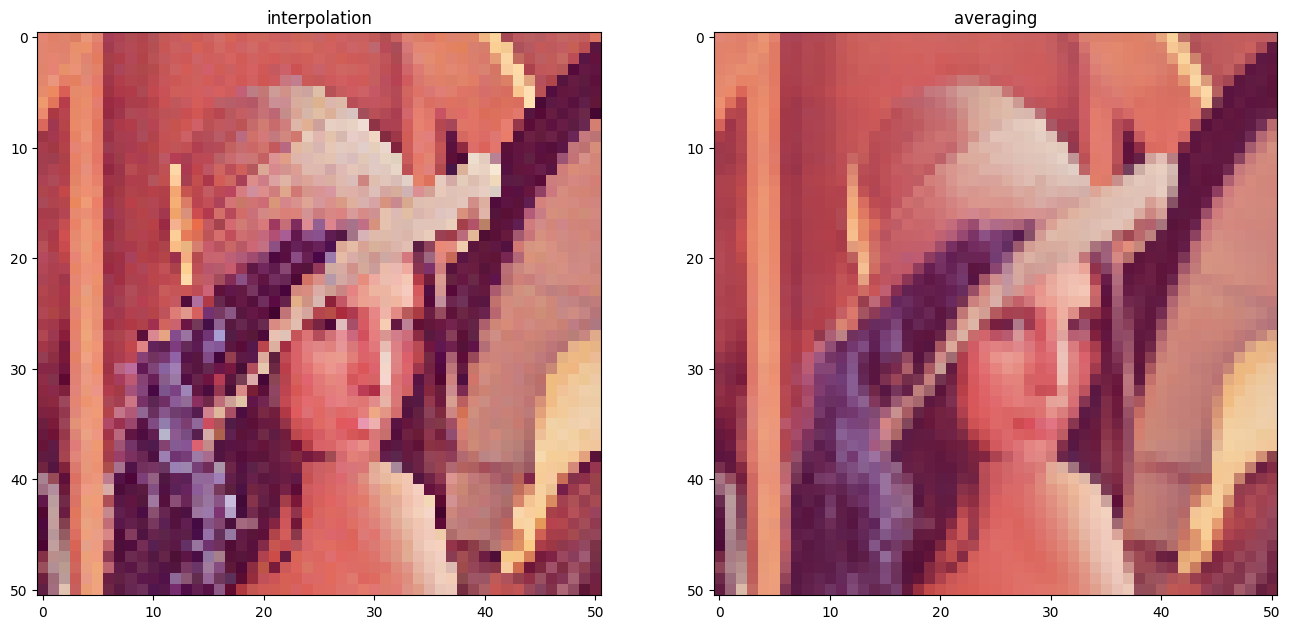

In [ ]:
figure, axes = plt.subplots(1, 2)
figure.set_figwidth(16)
figure.set_figheight(8)

axes[0].imshow(resized1)
axes[0].set_title("interpolation")

axes[1].imshow(resized2)
axes[1].set_title("averaging")

plt.show()

# Задание 3 Изменение яркости

In [ ]:
from PIL import Image, ImageOps

gray_img = ImageOps.grayscale(Image.fromarray(img))
gray_img = np.array(gray_img)

In [ ]:
def linear_hist_transform(img, percent=0.05):
  count = int(img.size * percent)
  p = np.sort(img.flatten())
  y_min = p[count]
  y_max = p[-count-1]
  return ((img - y_min) / (y_max - y_min) * 255)

In [ ]:
new_img = linear_hist_transform(gray_img)


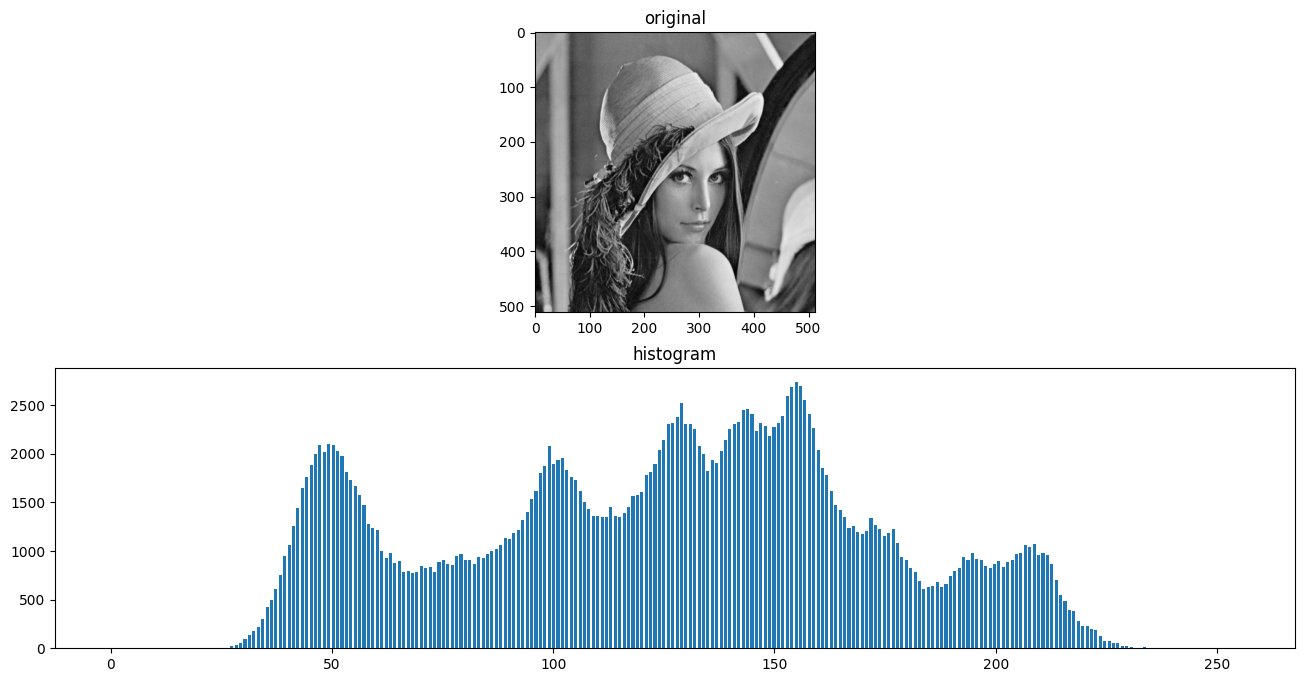

In [ ]:
figure, axes = plt.subplots(2, 1)
figure.set_figwidth(16)
figure.set_figheight(8)

axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title("original")

axes[1].hist(gray_img.flatten(), bins=256, range=(0, 255), rwidth=0.7)

axes[1].set_title("histogram")

plt.show()

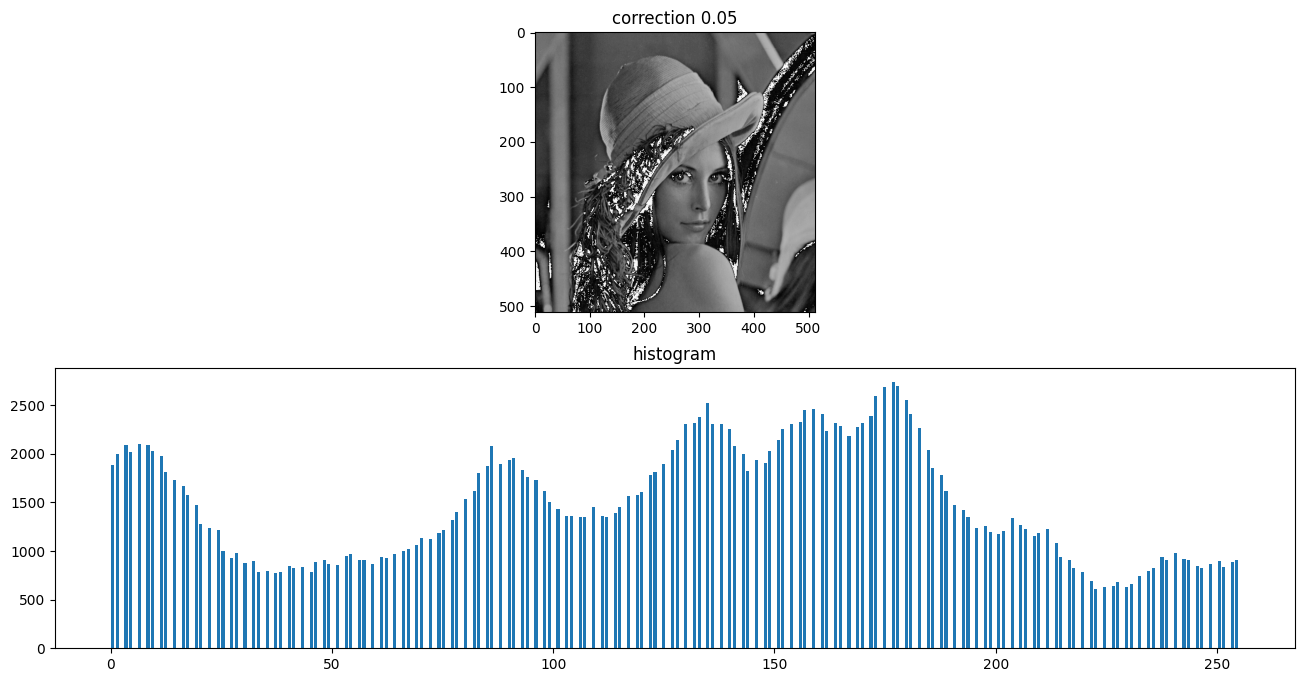

In [ ]:
figure, axes = plt.subplots(2, 1)
figure.set_figwidth(16)
figure.set_figheight(8)

axes[0].imshow(new_img, cmap='gray')
axes[0].set_title("correction 0.05")

axes[1].hist(new_img.flatten(), bins=256, range=(0, 255), rwidth=0.7)

axes[1].set_title("histogram")

plt.show()

# Задание 4 Гамма коррекция

In [ ]:
def gamma_correction(img, gamma=0.2):
  img_normalized = img / 255
  new_img = (img_normalized** gamma) * 255
  return new_img

Text(0.5, 1.0, 'gamma = 0.9')

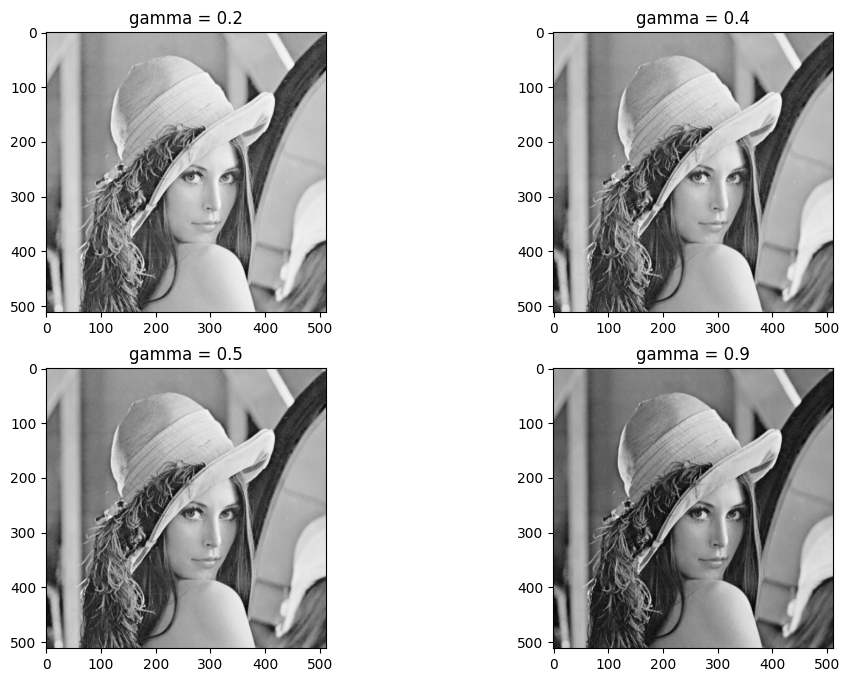

In [ ]:
figure, axes = plt.subplots(2, 2)
figure.set_figwidth(12)
figure.set_figheight(8)

axes[0][0].imshow(gamma_correction(gray_img), cmap='gray')
axes[0][0].set_title("gamma = 0.2")

axes[0][1].imshow(gamma_correction(gray_img, 0.4), cmap='gray')
axes[0][1].set_title("gamma = 0.4")

axes[1][0].imshow(gamma_correction(gray_img, 0.5), cmap='gray')
axes[1][0].set_title("gamma = 0.5")

axes[1][1].imshow(gamma_correction(gray_img, 0.9), cmap='gray')
axes[1][1].set_title("gamma = 0.9")

# Задание 5 Эквализация гистограммы

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Unequalized_Hawkes_Bay_NZ.jpg/300px-Unequalized_Hawkes_Bay_NZ.jpg"
urllib.request.urlretrieve(url, "image_heq.jpg")
img_heq = np.array(Image.open("image_heq.jpg"))


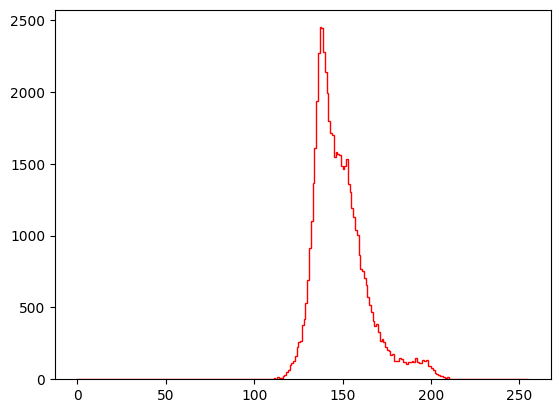

array([[148, 140, 144, ..., 172, 168, 161],
       [141, 137, 146, ..., 136, 135, 128],
       [137, 134, 146, ..., 153, 155, 151],
       ...,
       [137, 133, 131, ..., 143, 143, 144],
       [137, 133, 130, ..., 146, 146, 147],
       [136, 132, 129, ..., 142, 143, 144]], dtype=uint8)
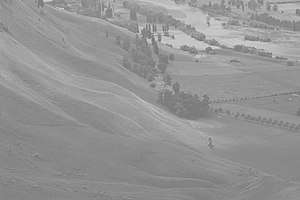

In [ ]:
plt.hist(img_heq.ravel(), bins=range(256),histtype = 'step', ec = 'r')
plt.show()
img_heq

In [ ]:
def hist_eq(img):
    number_bins=256
    img_histogram, bins = np.histogram(img.flatten(), number_bins, density=True)
    cdf = img_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize
    img_equalized = np.interp(img.flatten(), bins[:-1], cdf)
    return img_equalized.reshape(img.shape)

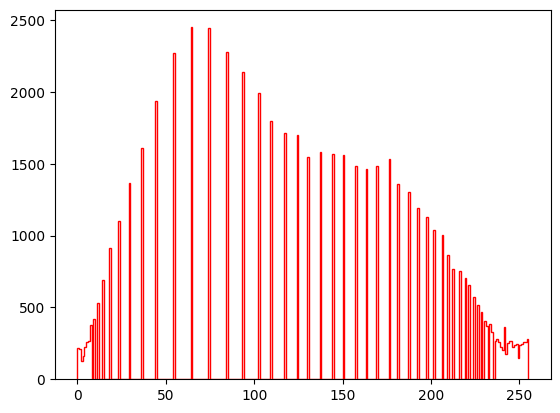

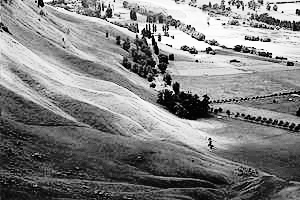

In [ ]:
eqd_img = hist_eq(img_heq)
plt.hist(np.array(eqd_img).ravel(), bins=range(256),histtype = 'step', ec = 'r')
plt.show()
cv2_imshow(eqd_img)